# Классификация знаков Дорожного Движения

In [1]:
# !pip install natsort

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [2]:
data = []
labels = []
sumu =0
start = 0
input_size = (60,60)
path = "./New_Dataset"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str("./New_Dataset/"+file_number)
    num = 0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
        count=0
        for file_number_3 in os.listdir(path3):
            if file_number == 'information_signs':
                if count == 500: break
            else: 
                if count == 200: break
            count = count+1
            imagepath = (path3 + "/" + str(file_number_3))
#             print(imagepath)
            image = cv2.imread(imagepath, 1) ## Считываем изображение
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
            image = transform.resize(image, input_size)
            data.append(image)

            label = file_number
            labels.append(label)
        num = num + count
        sumu = sumu+count
    print(label, num)
print('all',sumu)

add_information_signs 4184
Forbidding_signs 8303
information_signs 6241
prescriptive_signs 3919
priority_signs 1600
service_signs 3438
special_instructions_signs 7438
Warning_signs 7330
all 42453


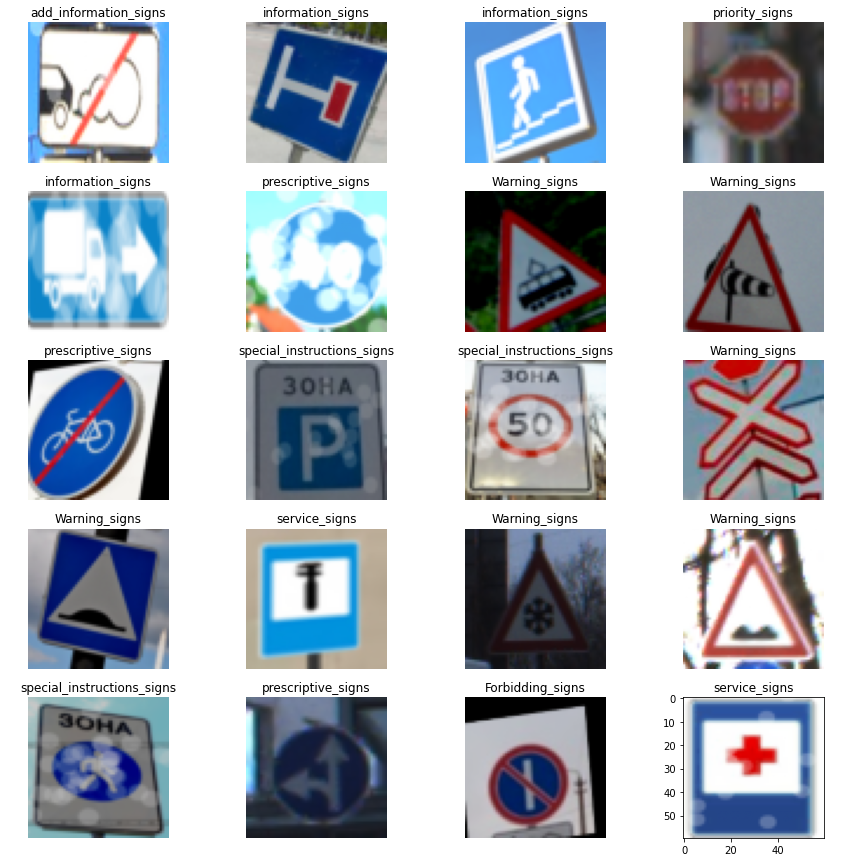

In [3]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU, GlobalAveragePooling2D
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

opt = SGD(learning_rate=0.008)
# opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))

model.add(GlobalAveragePooling2D())
# model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 31, 31, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)      

In [8]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=0.1, batch_size=40, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [9]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=20, epochs=100, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/100
1486/1486 [==============================] - 36s 19ms/step - loss: 1.2829 - f1_score: 0.4475 - val_loss: 0.7642 - val_f1_score: 0.6383
Epoch 2/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.6808 - f1_score: 0.6854 - val_loss: 0.4506 - val_f1_score: 0.8005
Epoch 3/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.4359 - f1_score: 0.8218 - val_loss: 0.2587 - val_f1_score: 0.8980
Epoch 4/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.3023 - f1_score: 0.8837 - val_loss: 0.1911 - val_f1_score: 0.9301
Epoch 5/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.2191 - f1_score: 0.9169 - val_loss: 0.1344 - val_f1_score: 0.9591
Epoch 6/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.1711 - f1_score: 0.9392 - val_loss: 0.1147 - val_f1_score: 0.9623
Epoch 7/100
1486/1486 [==============================] - 26s 17ms/step - loss: 0.1413 - f1_score: 0.9516 - val_loss: 0

1486/1486 [==============================] - 25s 17ms/step - loss: 0.0080 - f1_score: 0.9975 - val_loss: 0.0358 - val_f1_score: 0.9907
Epoch 57/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.0074 - f1_score: 0.9976 - val_loss: 0.0338 - val_f1_score: 0.9912
Epoch 58/100
1486/1486 [==============================] - 26s 17ms/step - loss: 0.0069 - f1_score: 0.9975 - val_loss: 0.0340 - val_f1_score: 0.9899
Epoch 59/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.0079 - f1_score: 0.9972 - val_loss: 0.0340 - val_f1_score: 0.9894
Epoch 60/100
1486/1486 [==============================] - 25s 17ms/step - loss: 0.0078 - f1_score: 0.9972 - val_loss: 0.0367 - val_f1_score: 0.9893
Epoch 61/100
1486/1486 [==============================] - 26s 17ms/step - loss: 0.0059 - f1_score: 0.9979 - val_loss: 0.0373 - val_f1_score: 0.9894
Epoch 62/100
1486/1486 [==============================] - 26s 17ms/step - loss: 0.0083 - f1_score: 0.9973 - val_loss: 0.0336 

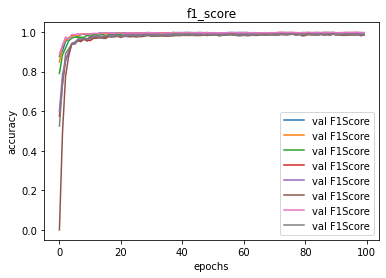

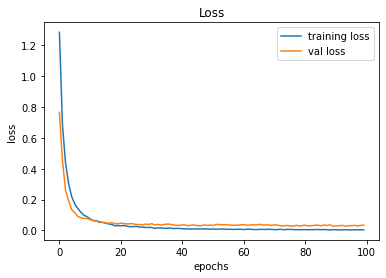

In [10]:
#plotting graphs for accuracy 
plt.figure(0)
# plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
# model.save('./saved_models/Trafic_Signs_CNN_categorical(45x45).h5')

In [12]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []
exmp_number = 20

In [13]:
class_all_0 = []
class_pred_0 = []

In [14]:
for c in range (0,11):
    for i in range(exmp_number):
        
        classid = 0
        all_classes.append(classid)
        class_all_0.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_0.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


In [15]:
for c in range (15,18):
    for i in range(exmp_number):
        
        classid = 0
        all_classes.append(classid)
        class_all_0.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_0.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step


In [16]:
for c in range (32,33):
    for i in range(exmp_number):
        
        classid = 0
        all_classes.append(classid)
        class_all_0.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_0.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 18ms/step


In [17]:
for c in range (41,43):
    for i in range(exmp_number):
        
        classid = 0
        all_classes.append(classid)
        class_all_0.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_0.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step


In [18]:
for c in range (72,98):
    for i in range(exmp_number):
        
        classid = 0
        all_classes.append(classid)
        class_all_0.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_0.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step
0 1 Test/77_1_13.png
1/1 [==============================] - 0s 16ms/step
0 1 Test/78_1_27.png
1/1 [==============================] - 0s 21ms/step
0 3 Test/78_1_14.png
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
0 2 Test/84_2_28.png
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
0 2 Test/90_7_20.png
1/1 [==============================] - 0s 17ms/step
0 4 Test/93_6_19.png
1/1 [==============================] - 0s 17ms/step
0 1 Test/95_5_29.png


1/1 [==============================] - 0s 31ms/step
0 2 Test/97_4_20.png
1/1 [==============================] - 0s 20ms/step


In [19]:
from sklearn.metrics import f1_score
print (f1_score(class_all_0, class_pred_0, average='weighted'))

0.9953271028037384


In [20]:
class_all_2 = []
class_pred_2 = []

In [21]:
for c in range (183,205):
    for i in range(exmp_number):
        
        classid = 2
        all_classes.append(classid)
        class_all_2.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_2.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step
2 3 Test/187_2_14.png
1/1 [==============================] - 0s 17ms/step
2 0 Test/189_3_22.png
1/1 [==============================] - 0s 17ms/step
2 0 Test/189_3_14.png
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 17ms/step
2 7 Test/191_6_8.png
1/1 [==============================] - 0s 7ms/step
2 3 Test/192_7_29.png
1/1 [==============================] - 0s 17ms/step
2 3 Test/192_2_19.png
1/1 [==============================] - 0s 17ms/step
2 3 Test/192_2_10.png
1/1 [==============================] - 0s 16ms/step
2 3 Test/192_3_19.png
1/1 [==============================] - 0s 7ms/step
2 7 Test/192_4_8.png
1/1 [==============================] - 0s 16ms/step
2 3 Test/192_3_1.png
1/1 [==============================] - 0s 16ms/step
2 0 Test/194_1_25.png
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 6ms/step


In [22]:
from sklearn.metrics import f1_score
print (f1_score(class_all_2, class_pred_2, average='weighted'))

0.9873417721518987


In [23]:
class_all_3 = []
class_pred_3 = []

In [24]:
for c in range (148,165):
    for i in range(exmp_number):
        
        classid = 3
        all_classes.append(classid)
        class_all_3.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_3.append(prediction[0])
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 7ms/step
3 4 Test/149_6_21.png
1/1 [==============================] - 0s 17ms/step
3 7 Test/151_6_27.png
1/1 [==============================] - 0s 17ms/step
3 4 Test/151_1_9.png
1/1 [==============================] - 0s 30ms/step
3 7 Test/152_3_5.png
1/1 [==============================] - 0s 17ms/step
3 7 Test/152_3_16.png
1/1 [==============================] - 0s 6ms/step
3 6 Test/152_3_1.png
1/1 [==============================] - 0s 16ms/step
3 7 Test/152_3_19.png
1/1 [==============================] - 0s 18ms/step
3 7 Test/153_4_10.png
1/1 [==============================] - 0s 7ms/step
3 4 Test/153_2_17.png
1/1 [==============================] - 0s 9ms/step
3 4 Test/153_7_11.png
1/1 [==============================] - 0s 21ms/step
3 2 Test/154_1_0.png
1/1 [==============================] - 0s 17ms/step
3 0 Test/154_1_24.png
1/1 [==============================] - 0s 17ms/step
3 4 Test/154_1_10.png
1/1 [==============================] - 0s 18ms

1/1 [==============================] - 0s 26ms/step
3 4 Test/156_3_8.png
1/1 [==============================] - 0s 16ms/step
3 4 Test/157_4_14.png
1/1 [==============================] - 0s 16ms/step
3 0 Test/158_3_16.png
1/1 [==============================] - 0s 16ms/step
3 7 Test/159_1_8.png
1/1 [==============================] - 0s 16ms/step
3 2 Test/159_3_20.png
1/1 [==============================] - 0s 8ms/step
3 1 Test/159_1_26.png
1/1 [==============================] - 0s 16ms/step
3 2 Test/159_3_29.png
1/1 [==============================] - 0s 16ms/step
3 1 Test/159_1_16.png
1/1 [==============================] - 0s 16ms/step
3 7 Test/159_5_8.png
1/1 [==============================] - 0s 17ms/step
3 2 Test/159_1_28.png
1/1 [==============================] - 0s 11ms/step
3 1 Test/160_3_30.png
1/1 [==============================] - 0s 31ms/step
3 7 Test/160_2_8.png
1/1 [==============================] - 0s 11ms/step
3 7 Test/160_2_25.png
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 31ms/step
3 2 Test/164_5_16.png
1/1 [==============================] - 0s 16ms/step
3 0 Test/164_2_29.png
1/1 [==============================] - 0s 16ms/step
3 2 Test/164_1_1.png
1/1 [==============================] - 0s 17ms/step
3 7 Test/164_4_13.png
1/1 [==============================] - 0s 16ms/step
3 2 Test/164_4_1.png
1/1 [==============================] - 0s 8ms/step


In [25]:
from sklearn.metrics import f1_score
print (f1_score(class_all_3, class_pred_3, average='weighted'))

0.9424572317262833


In [26]:
class_all_4 = []
class_pred_4 = []

In [27]:
for c in range (33,41):
    for i in range(exmp_number):
        
        classid = 4
        all_classes.append(classid)
        class_all_4.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_4.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 18ms/step
4 0 Test/03465.png
1/1 [==============================] - 0s 31ms/step
4 0 Test/06862.png
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


In [28]:
for c in range (98,110):
    for i in range(exmp_number):
        
        classid = 4
        all_classes.append(classid)
        class_all_4.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_4.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 6ms/step
4 3 Test/98_7_17.png
1/1 [==============================] - 0s 17ms/step
4 3 Test/98_7_21.png
1/1 [==============================] - 0s 18ms/step
4 0 Test/102_3_24.png
1/1 [==============================] - 0s 16ms/step
4 7 Test/102_7_25.png
1/1 [==============================] - 0s 17ms/step
4 0 Test/102_1_19.png
1/1 [==============================] - 0s 16ms/step
4 7 Test/102_1_2.png
1/1 [==============================] - 0s 16ms/step
4 1 Test/104_1_14.png
1/1 [==============================] - 0s 11ms/step
4 7 Test/105_4_4.png
1/1 [==============================] - 0s 16ms/step
4 3 Test/105_4_19.png
1/1 [==============================] - 0s 11ms/step
4 3 Test/105_4_1.png
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 5ms/step
4 7 Test/106_2_28.png
1/1 [==============================] - 0s 16ms/step
4 7 Test/108_6_32.png
1/1 [==============================] - 0s 16ms/step
4 7 Test/108_1_27.png
1/1 [==============================] - 0s 18ms/step
4 6 Test/109_2_16.png
1/1 [==============================] - 0s 18ms/step
4 6 Test/109_5_22.png
1/1 [==============================] - 0s 17ms/step
4 6 Test/109_7_16.png
1/1 [==============================] - 0s 9ms/step


In [29]:
from sklearn.metrics import f1_score
print (f1_score(class_all_4, class_pred_4, average='weighted'))

0.9769820971867007


In [30]:
class_all_5 = []
class_pred_5 = []

In [31]:
for c in range (12,15):
    for i in range(exmp_number):
        
        classid = 5
        all_classes.append(classid)
        class_all_5.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_5.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 29ms/step
5 0 Test/01271.png
1/1 [==============================] - 0s 17ms/step
5 4 Test/10359.png
1/1 [==============================] - 0s 17ms/step
5 4 Test/04983.png
1/1 [==============================] - 0s 20ms/step
5 4 Test/10324.png
1/1 [==============================] - 0s 14ms/step
5 0 Test/11459.png
1/1 [==============================] - 0s 15ms/step
5 0 Test/00578.png
1/1 [==============================] - 0s 18ms/step
5 0 Test/11093.png
1/1 [==============================] - 0s 17ms/step
5 0 Test/08994.png


In [32]:
for c in range (43,48):
    for i in range(exmp_number):
        
        classid = 5
        all_classes.append(classid)
        class_all_5.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_5.append(prediction[0])
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 7ms/step
5 0 Test/43_1_30.png
1/1 [==============================] - 0s 21ms/step
5 1 Test/44_4_29.png
1/1 [==============================] - 0s 9ms/step
5 1 Test/44_2_18.png
1/1 [==============================] - 0s 17ms/step
5 1 Test/44_5_9.png
1/1 [==============================] - 0s 17ms/step
5 1 Test/44_4_24.png
1/1 [==============================] - 0s 19ms/step
5 1 Test/45_6_29.png
1/1 [==============================] - 0s 17ms/step
5 1 Test/45_6_20.png
1/1 [==============================] - 0s 17ms/step
5 0 Test/46_6_34.png
1/1 [==============================] - 0s 17ms/step
5 2 Test/46_6_25.png
1/1 [==============================] - 0s 17ms/step
5 2 Test/46_3_20.png
1/1 [==============================] - 0s 22ms/step
5 0 Test/46_1_29.png
1/1 [==============================] - 0s 17ms/step


In [33]:
from sklearn.metrics import f1_score
print (f1_score(class_all_5, class_pred_5, average='weighted'))

0.93687707641196


In [34]:
class_all_6 = []
class_pred_6 = []

In [35]:
for c in range (165,183):
    for i in range(exmp_number):
        
        classid = 6
        all_classes.append(classid)
        class_all_6.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_6.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 14ms/step
6 3 Test/167_2_11.png
1/1 [==============================] - 0s 5ms/step
6 2 Test/168_7_26.png
1/1 [==============================] - 0s 16ms/step
6 3 Test/169_5_20.png
1/1 [==============================] - 0s 17ms/step
6 0 Test/172_1_29.png
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 9ms/step
6 2 Test/173_1_24.png
1/1 [==============================] - 0s 12ms/step
6 7 Test/176_5_22.png
1/1 [==============================] - 0s 18ms/step
6 7 Test/176_2_22.png
1/1 [==============================] - 0s 17ms/step
6 7 Test/176_2_18.png
1/1 [==============================] - 0s 18ms/step
6 4 Test/176_2_28.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
6 2 Test/180_5_22.png
1/1 [==============================] - 0s 16ms/step
6 7 Test/180_1_27.png
1/1 [==============================] - 0s 16ms/step
6 2 Test/181_7_11.png
1/1 [==============================] - 0s 17ms/step


In [36]:
from sklearn.metrics import f1_score
print (f1_score(class_all_6, class_pred_6, average='weighted'))

0.983050847457627


In [37]:
class_all_7 = []
class_pred_7 = []

In [38]:
for c in range (110,148):
    for i in range(exmp_number):
        
        classid = 7
        all_classes.append(classid)
        class_all_7.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_7.append(prediction[0])
        
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 12ms/step
7 3 Test/110_1_29.png
1/1 [==============================] - 0s 17ms/step
7 2 Test/111_1_26.png
1/1 [==============================] - 0s 18ms/step
7 4 Test/113_7_20.png
1/1 [==============================] - 0s 10ms/step
7 3 Test/114_5_21.png
1/1 [==============================] - 0s 32ms/step
7 3 Test/114_5_2.png
1/1 [==============================] - 0s 19ms/step
7 3 Test/114_6_24.png
1/1 [==============================] - 0s 17ms/step
7 3 Test/114_6_34.png
1/1 [==============================] - 0s 3ms/step
7 3 Test/114_5_12.png
1/1 [==============================] - 0s 17ms/step
7 3 Test/114_5_18.png
1/1 [==============================] - 0s 14ms/step
7 3 Test/114_6_27.png
1/1 [==============================] - 0s 19ms/step
7 3 Test/114_5_27.png
1/1 [==============================] - 0s 11ms/step
7 3 Test/116_1_5.png
1/1 [==============================] - 0s 17ms/step
7 4 Test/116_1_13.png
1/1 [==============================] - 0s

1/1 [==============================] - 0s 3ms/step
7 4 Test/117_2_36.png
1/1 [==============================] - 0s 13ms/step
7 4 Test/117_2_21.png
1/1 [==============================] - 0s 20ms/step
7 3 Test/117_3_19.png
1/1 [==============================] - 0s 3ms/step
7 3 Test/118_4_30.png
1/1 [==============================] - 0s 9ms/step
7 3 Test/119_1_29.png
1/1 [==============================] - 0s 20ms/step
7 4 Test/119_5_12.png
1/1 [==============================] - 0s 17ms/step
7 2 Test/119_2_35.png
1/1 [==============================] - 0s 17ms/step
7 4 Test/120_3_10.png
1/1 [==============================] - 0s 18ms/step
7 3 Test/121_1_36.png
1/1 [==============================] - 0s 17ms/step
7 4 Test/122_4_18.png
1/1 [==============================] - 0s 17ms/step
7 4 Test/122_5_22.png
1/1 [==============================] - 0s 18ms/step
7 4 Test/124_5_8.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
7 3 Test/128_7_38.png
1/1 [==============================] - 0s 4ms/step
7 4 Test/129_1_16.png
1/1 [==============================] - 0s 15ms/step
7 0 Test/129_7_24.png
1/1 [==============================] - 0s 9ms/step
7 4 Test/130_5_21.png
1/1 [==============================] - 0s 8ms/step
7 3 Test/130_6_33.png
1/1 [==============================] - 0s 22ms/step
7 3 Test/130_3_8.png
1/1 [==============================] - 0s 12ms/step
7 4 Test/130_7_11.png
1/1 [==============================] - 0s 18ms/step
7 3 Test/130_6_29.png
1/1 [==============================] - 0s 17ms/step
7 3 Test/130_4_5.png
1/1 [==============================] - 0s 17ms/step
7 3 Test/130_6_11.png
1/1 [==============================] - 0s 16ms/step
7 4 Test/131_5_18.png
1/1 [==============================] - 0s 23ms/step
7 3 Test/131_7_3.png
1/1 [==============================] - 0s 16ms/step
7 3 Test/131_7_27.png
1/1 [==============================] - 0s 17

1/1 [==============================] - 0s 32ms/step
7 2 Test/133_3_26.png
1/1 [==============================] - 0s 30ms/step
7 6 Test/133_5_29.png
1/1 [==============================] - 0s 16ms/step
7 6 Test/133_3_6.png
1/1 [==============================] - 0s 27ms/step
7 6 Test/133_3_16.png
1/1 [==============================] - 0s 9ms/step
7 3 Test/133_1_2.png
1/1 [==============================] - 0s 16ms/step
7 3 Test/133_3_29.png
1/1 [==============================] - 0s 16ms/step
7 6 Test/133_3_8.png
1/1 [==============================] - 0s 7ms/step
7 6 Test/133_3_22.png
1/1 [==============================] - 0s 16ms/step
7 3 Test/134_6_33.png
1/1 [==============================] - 0s 17ms/step
7 6 Test/135_5_28.png
1/1 [==============================] - 0s 17ms/step
7 6 Test/135_7_2.png
1/1 [==============================] - 0s 17ms/step
7 6 Test/135_1_0.png
1/1 [==============================] - 0s 18ms/step
7 6 Test/135_4_3.png
1/1 [==============================] - 0s 17ms

1/1 [==============================] - 0s 16ms/step
7 2 Test/139_4_32.png
1/1 [==============================] - 0s 16ms/step
7 2 Test/139_4_34.png
1/1 [==============================] - 0s 18ms/step
7 0 Test/140_2_24.png
1/1 [==============================] - 0s 17ms/step
7 4 Test/140_3_17.png
1/1 [==============================] - 0s 16ms/step
7 0 Test/140_6_30.png
1/1 [==============================] - 0s 22ms/step
7 2 Test/141_1_19.png
1/1 [==============================] - 0s 17ms/step
7 2 Test/141_4_10.png
1/1 [==============================] - 0s 18ms/step
7 3 Test/142_3_11.png
1/1 [==============================] - 0s 4ms/step
7 2 Test/142_7_9.png
1/1 [==============================] - 0s 17ms/step
7 3 Test/142_3_5.png
1/1 [==============================] - 0s 5ms/step
7 2 Test/142_7_36.png
1/1 [==============================] - 0s 17ms/step
7 2 Test/142_7_2.png
1/1 [==============================] - 0s 15ms/step
7 3 Test/142_6_22.png
1/1 [==============================] - 0s 8

1/1 [==============================] - 0s 15ms/step
7 2 Test/147_5_18.png
1/1 [==============================] - 0s 16ms/step
7 2 Test/147_5_33.png
1/1 [==============================] - 0s 16ms/step


In [39]:
from sklearn.metrics import f1_score
print (f1_score(class_all_7, class_pred_7, average='weighted'))

0.9173789173789174


In [40]:
class_all_1 = []
class_pred_1 = []

In [41]:
for c in range (18,32):
    for i in range(exmp_number):
        
        classid = 1
        all_classes.append(classid)
        class_all_1.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_1.append(prediction[0])
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step
1 5 Test/05577.png
1/1 [==============================] - 0s 17ms/step
1 5 Test/08373.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step


In [ ]:
for c in range (48,72):
    for i in range(exmp_number):
        
        classid = 1
        all_classes.append(classid)
        class_all_1.append(classid)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
    
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(prediction[0])
        class_pred_1.append(prediction[0])
        if classid != prediction[0]:
             print(classid,prediction[0], image_path)


1/1 [==============================] - 0s 20ms/step
1 0 Test/48_7_38.png
1/1 [==============================] - 0s 18ms/step
1 2 Test/51_2_1.png
1/1 [==============================] - 0s 17ms/step
1 3 Test/51_2_9.png
1/1 [==============================] - 0s 17ms/step
1 5 Test/53_4_9.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step
1 5 Test/57_3_18.png
1/1 [==============================] - 0s 19ms/step
1 7 Test/60_5_17.png
1/1 [==============================] - 0s 18ms/step
1 2 Test/63_5_20.png
1/1 [==============================] - 0s 13ms/step
1 2 Test/63_5_27.png


1/1 [==============================] - 0s 17ms/step
1 2 Test/63_5_17.png
1/1 [==============================] - 0s 17ms/step
1 2 Test/65_6_5.png
1/1 [==============================] - 0s 27ms/step
1 0 Test/65_6_16.png
1/1 [==============================] - 0s 10ms/step


In [ ]:
from sklearn.metrics import f1_score
print (f1_score(class_all_1, class_pred_1, average='weighted'))

In [ ]:
from sklearn.metrics import f1_score
print (f1_score(all_classes, predicted_classes, average='weighted'))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')